In [72]:
import os
import random
import pickle
from collections import deque

import gym
import numpy as np
import pandas as pd
import sqlite3 as sql
import matplotlib.pyplot as plt
from scipy.stats import pearsonr

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.optimizers import Adam

from support_code.functions import buy_and_hold, corr, fetch_data

In [73]:
import gym
import numpy as np
import pandas as pd

class TradingEnv(gym.Env):
    
    metadata = {'render.modes': ['human']}

    def __init__(self, df, balance_init, actions=9, training=True, train_size=0.8, fee=0.001):
        
        super(TradingEnv, self).__init__()
        assert actions in [5, 7, 9, 11, 21]
        
        self.df = df.copy()
        self.df['date'] = pd.to_datetime(self.df['date'])
        self.df.sort_values('date', inplace=True, ascending=False)
        
        self.balance_init = balance_init
        self.fee = fee
        
        self.verbose = 0
        self.training = training
        self.train_test_split = int(self.df.shape[0]*train_size)
        
        self.action_space = gym.spaces.Box(low=-1, high=1, shape=(1,))
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(6,5))
        
    def _next_observation(self):
                
        self.max_price = np.max(self.df.drop(['date', 'volume'], axis=1).loc[self.current_step:self.first_step-4].values)
        self.max_vol = np.max(self.df.loc[self.current_step:self.first_step-4]['volume'])
        
        obs = self.df.loc[self.current_step: self.current_step-4].copy()
        
        obs[['open', 'high', 'low', 'close']] /= self.max_price
        obs['volume'] /= self.max_vol
        
        obs = obs.drop('date', axis=1).values
        
        obs = np.vstack((obs, [ 
            self.net_worth/self.balance_init, 
            self.balance/self.balance_init,
            self.shares_held,
            self.current_step-self.first_step,
            self.shares_held/self.df.loc[self.current_step, 'close'],
            ]))         

        assert obs.shape == self.observation_space.shape
        return obs
    
    def _take_action_verbose(self, action):
        
        current_price = self.df.loc[self.current_step, 'close']
        
        print('current price', current_price)
        print('action', action)
                
        if action > 0:
            total_possible = self.balance / (current_price*(1+self.fee))
            print('total possible to buy', total_possible)
            n_shares_bought = total_possible * action
            print('number bought', n_shares_bought)
                        
            cost = n_shares_bought * current_price
            cost *= (1 + self.fee)
            print('cost of buying', cost)
            
            self.balance -= cost
            self.shares_held += n_shares_bought
            print('balance', self.balance, 'shares held', self.shares_held)
            
        if action < 0:
            total_possible = self.shares_held * 1
            print('total possible to sell', total_possible)
            n_shares_sold = total_possible * -action
            print('number sold', n_shares_sold)
                        
            profit = n_shares_sold * current_price
            profit *= (1 - self.fee)
            print('profit from selling', profit)
            
            self.balance += profit
            self.shares_held -= n_shares_sold
            print('balance', self.balance, 'shares held', self.shares_held)
            
        if action == 0:
            self.balance = self.balance
            self.shares_held = self.shares_held
            print('balance', self.balance, 'shares held', self.shares_held)
            
        self.net_worth_prev = self.net_worth
        self.net_worth = self.balance + (self.shares_held*current_price)
        print('previous net worth', self.net_worth_prev, 'current net worth', self.net_worth)
        
        print()
        
        return self
    
    def _take_action_nonverbose(self, action):
        
        current_price = self.df.loc[self.current_step, 'close']

        if action > 0:
            total_possible = self.balance / (current_price*(1+self.fee))
            n_shares_bought = total_possible * action
                        
            cost = n_shares_bought * current_price
            cost *= (1 + self.fee)
            
            self.balance -= cost
            self.shares_held += n_shares_bought
            
        if action < 0:
            total_possible = self.shares_held * 1
            n_shares_sold = total_possible * -action
                        
            profit = n_shares_sold * current_price
            profit *= (1 - self.fee)
            
            self.balance += profit
            self.shares_held -= n_shares_sold
            
        if action == 0:
            self.balance = self.balance
            self.shares_held = self.shares_held
            
        self.net_worth = self.balance + (self.shares_held*current_price)
        
        return self
                
    def _reward_fn(self):

        current_price = self.df.loc[self.current_step, 'close']
        total_possible = self.balance_long / (current_price*(1+self.fee))
        cost = total_possible * current_price
        cost *= (1+self.fee)

        self.balance_long -= cost
        self.shares_held_long += total_possible
        self.net_worth_long = self.balance_long + (self.shares_held_long*current_price)
        
        profit = self.net_worth - self.balance_init
        profit_long = self.net_worth_long - self.balance_init

        return (profit - profit_long) / self.balance_init
    
    def step(self, action):
                
        if self.verbose > 0:
            self._take_action_verbose(action)
        elif self.verbose <= 0:
            self._take_action_nonverbose(action)
        self.current_step += 1
        
        # done
        if self.training:
            done = (self.balance < 0 or self.current_step >= self.train_test_split)
        else:
            done = (self.balance < 0 or self.current_step <= self.df.index[-2])
           
        # obs
        obs = self._next_observation()

        # reward
        reward = self._reward_fn()
        
        return obs, reward, done, {}
            
    def reset(self):
        
        if self.training: 
            self.current_step = np.random.randint(5, self.train_test_split-10)
        else: 
            self.current_step = self.train_test_split
        self.first_step = self.current_step
        
        self.net_worth = self.balance_init
        self.balance = self.balance_init
        self.shares_held = 0
        
        self.net_worth_long = self.balance_init
        self.balance_long = self.balance_init
        self.shares_held_long = 0
    
        return self._next_observation()
    
    
    def render(self, mode='human'):
        
        print('Current balance:', self.balance)
        print('Current net worth:', self.net_worth)
        print('Shares held:', self.shares_held)
        print('Profit:', self.net_worth - self.balance_init)
        print('Day range:', self.first_step, self.current_step)
        print('Today:', self.df.loc[self.current_step], sep='\n')
        
    def close(self):
        
        pass
               

In [74]:
def build_action_network(input_shape):
    
    h1 = 1528
    h2 = 1032
    eta = 0.01
    
    model = Sequential()
    
    model.add( # Hidden layer 1
        Dense(
            units=h1, 
            activation='relu',
            input_shape=(input_shape,),
            )
        )

    model.add( # Hidden layer 2
        Dense(
            units=h2, 
            activation='relu',
            )
        )

    model.add( # Output layer
        Dense(
            units=1, 
            activation='tanh',
            )
        )
    
    model.compile(
        loss='mse',
        optimizer=Adam(lr=eta),
        )
    
    return model   

In [75]:
def build_value_network(input_shape, output_len):
        
    h1 = 1016
    h2 = 968
    eta = 0.01
    
    model = Sequential()
    
    model.add( # Input layer
        Flatten(
            input_shape=input_shape,
            )
        )
    
    model.add( # Hidden layer 1
        Dense(
            units=h1, 
            activation='relu',
            )
        )

    model.add( # Hidden layer 2
        Dense(
            units=h2, 
            activation='relu',
            )
        )

    model.add( # Output layer
        Dense(
            units=output_len, 
            activation='linear',
            )
        )
    
    model.compile(
        loss='mse',
        optimizer=Adam(lr=eta),
        )
    
    return model   

In [76]:
class DoubleDQN:
    
    def __init__(self, state_space, embeddings, 
        gamma=0.95, memory_size=1_000_000, batch_size=64, alpha=1.0, alpha_min=0.01, alpha_decay=0.99,
                ):
        
        self.gamma = gamma
        self.batch_size = batch_size
        self.alpha = alpha
        self.alpha_min = alpha_min
        self.alpha_decay = alpha_decay
        
        self.state_space = state_space
        self.embeddings = embeddings
        self.memory = deque(maxlen=memory_size)
        
        self.value_network = build_value_network(state_space, len(embeddings))
        self.action_network = build_action_network(len(embeddings))
        
        self.is_fit = False
        self.verbose = 0
        
    def act(self, state):

        if np.random.rand() < self.alpha:
            action = np.random.uniform(-1, 1)
        
        else:
            if self.is_fit:
                q_values = self.value_network.predict(
                    state.astype(float).reshape(1, *self.state_space)
                    )
                action = self.action_network.predict(
                    q_values.astype(float)
                    )[0][0]

            else:
                q_values = [np.random.randn(len(self.embeddings))]
                action = self.embeddings[
                    np.argmax(q_values[0])
                    ]

        return action
        
        
    def remember(self, state, action, reward, state_next, terminal):
        
        self.memory.append(
            (state, action, reward, state_next, terminal)
            )
        
        return self
    
    def replay(self):
        
        if len(self.memory) < self.batch_size:
            self.alpha = max(self.alpha_min, self.alpha*self.alpha_decay)
            return None
        
        X, Y, a = [], [], []
        mini_batch = random.sample(self.memory, self.batch_size)
        
        for state, action, reward, state_next, terminal in mini_batch:
            
            a.append(action)
            action_to_embedding = {e:np.abs(action-e) for e in self.embeddings}
            action = int(np.where(
                self.embeddings==min(
                    action_to_embedding, 
                    key=action_to_embedding.get,
                    )
                )[0])
            
            if terminal:
                q_update = reward
            
            else:
                if self.is_fit:
                    q_update = reward + self.gamma*np.amax(
                        self.value_network.predict(state_next.astype(float).reshape(1, *self.state_space))[0]
                        )
                else:
                    q_update = reward
            
            if self.is_fit:
                q_values = self.value_network.predict(state.astype(float).reshape(1, *self.state_space))
            else:
                q_values = np.zeros((1, len(self.embeddings)))
                
            q_values[0][action] = q_update
            
            X.append(state)
            Y.append(q_values[0])
            
        X = np.array(X).reshape(self.batch_size, *self.state_space)
        Y = np.array(Y).reshape(self.batch_size, len(self.embeddings))
        a = np.array(a).reshape(self.batch_size, 1)
        
        batch = max(8, int(self.batch_size/8))
        self.value_network.fit(
            X.astype(float), 
            Y.astype(float), 
            batch_size=batch, 
            epochs=25, 
            verbose=self.verbose,
            )
        
        values = self.value_network.predict(X.astype(float))
        
        self.action_network.fit(
            values.astype(float),
            a.astype(float),
            batch_size=batch,
            epochs=25,
            verbose=self.verbose)
        
        self.is_fit = True
        self.alpha = max(self.alpha_min, self.alpha*self.alpha_decay)
        
        return values, a
        
        

---

In [77]:
df = fetch_data('nflx_df')
#df.shape

In [78]:
np.random.seed(None)

starting_balance = 1_000_000

env = TradingEnv(df, balance_init=starting_balance)
env.verbose=0
env.seed(None)

print(env.action_space, env.observation_space)

Box(1,) Box(6, 5)


In [79]:
dqn_solver = DoubleDQN(
    state_space=env.observation_space.shape, 
    embeddings=np.linspace(-1,1,9),
    batch_size=64,
    memory_size=1_000_000,
    alpha=0.99,
    alpha_decay=0.9,
    alpha_min=0.01,
    )

dqn_solver.verbose = 0

In [80]:
dqn_solver.value_network.summary()

Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten_6 (Flatten)          (None, 30)                0         
_________________________________________________________________
dense_36 (Dense)             (None, 1016)              31496     
_________________________________________________________________
dense_37 (Dense)             (None, 968)               984456    
_________________________________________________________________
dense_38 (Dense)             (None, 9)                 8721      
Total params: 1,024,673
Trainable params: 1,024,673
Non-trainable params: 0
_________________________________________________________________


In [82]:
dqn_solver.action_network.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_39 (Dense)             (None, 1528)              15280     
_________________________________________________________________
dense_40 (Dense)             (None, 1032)              1577928   
_________________________________________________________________
dense_41 (Dense)             (None, 1)                 1033      
Total params: 1,594,241
Trainable params: 1,594,241
Non-trainable params: 0
_________________________________________________________________


In [83]:
history = []

In [84]:
for i in np.arange(100):
    
    # Reset the evironment at the top of each episode
    state = env.reset()
    
    stock_performance = []
    model_performance = []
    reward_trace = []    
    actions = []
    
    start = env.current_step
    done = False    
    
    # The model will iterate until a terminal state is reached
    while not done:
                
        # Select an action by passing the current observation/state to the DQN
        action = dqn_solver.act(state)
        
        # The environment takes a step according to that action and returns the new state, the reward, and the terminal status
        next_state, reward, done, info = env.step(action)
                
        # Commit to the DQN's memory the relevant information
        dqn_solver.remember(state, action, reward, next_state, done)
        
        # Update the current state
        state = next_state

        actions.append(action)
        reward_trace.append(reward)
        model_performance.append(env.net_worth)  
        stock_performance.append(df.loc[env.current_step]['close'])
            
    print('================================================================================================================')
    print(i+1)
    print('TOTAL REWARD:', sum(reward_trace))
    print('DAY RANGE:', start, env.current_step)
    print('EXPLORATION:', dqn_solver.alpha)
    print('MEMORY SIZE:', len(dqn_solver.memory))
    print('================================================================================================================')
    
    # After each episode, perform experience replay
    test = dqn_solver.replay()  
    
    print('\n\n\n')
    
    history.append({
        'stock': stock_performance,
        'model': model_performance,
        'actions': actions,
        'rewards': sum(reward_trace),
        })

X, y = test

1
TOTAL REWARD: 0.27340227316819427
DAY RANGE: 1272 1420
EXPLORATION: 0.99




2
TOTAL REWARD: -4816.944146870767
DAY RANGE: 35 1395
EXPLORATION: 0.891




3
TOTAL REWARD: -280.58190954618226
DAY RANGE: 1760 2357
EXPLORATION: 0.8019000000000001




4
TOTAL REWARD: -5857.696513421113
DAY RANGE: 787 2357
EXPLORATION: 0.7217100000000001




5
TOTAL REWARD: -91.26768731438668
DAY RANGE: 2136 2357
EXPLORATION: 0.6495390000000001




6
TOTAL REWARD: -1482.7105751266267
DAY RANGE: 1194 2357
EXPLORATION: 0.5845851000000001




7
TOTAL REWARD: -12539.579893493474
DAY RANGE: 957 2357
EXPLORATION: 0.5261265900000001




8
TOTAL REWARD: -29145.127823573388
DAY RANGE: 39 2357
EXPLORATION: 0.47351393100000005




9
TOTAL REWARD: -847.3018995823791
DAY RANGE: 1401 2357
EXPLORATION: 0.4261625379000001




10
TOTAL REWARD: -40.925636628909395
DAY RANGE: 2205 2357
EXPLORATION: 0.3835462841100001




11
TOTAL REWARD: -936.7920845412461
DAY RANGE: 1446 2357
EXPLORATION: 0.34519165569900007




12
TOTAL RE

SystemError: <built-in function TF_NewBuffer> returned a result with an error set

In [85]:
i = 10

In [86]:
long = buy_and_hold(
    balance_init=env.balance_init,
    back_prices=history[i]['stock'],
    fee=env.fee
    )

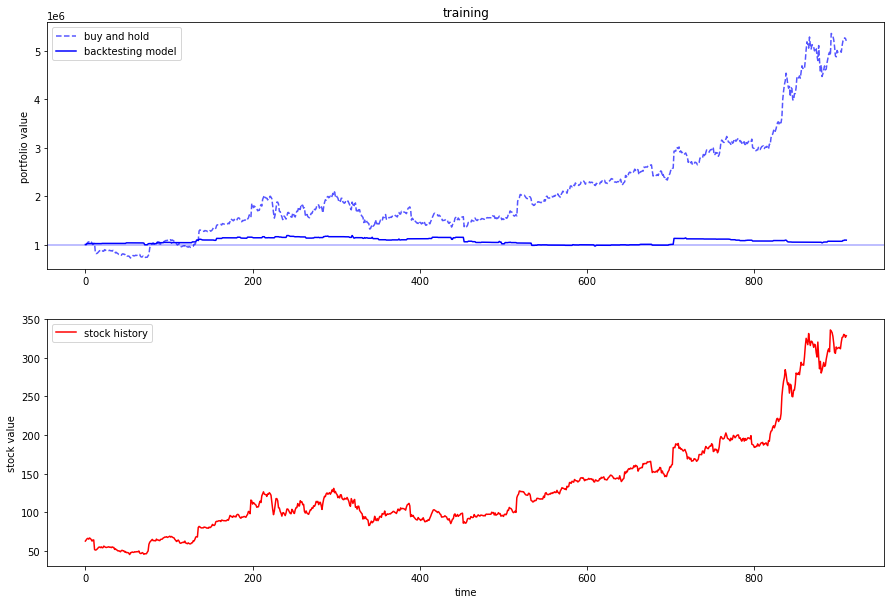

In [87]:
fig = plt.figure(figsize=(15,10))
ax1 = fig.add_subplot(211)
ax2 = fig.add_subplot(212)

ax1.plot(long, 'b--', alpha=0.667, label='buy and hold')
ax1.plot(history[i]['model'], 'b-', label='backtesting model')
ax1.axhline(env.balance_init, alpha=0.333, color='blue')
ax1.set_ylabel('portfolio value')
ax1.set_title('training')
ax1.legend()

ax2.plot(history[i]['stock'], 'r-', label='stock history')
ax2.set_ylabel('stock value')
ax2.set_xlabel('time')
ax2.legend()

plt.show();

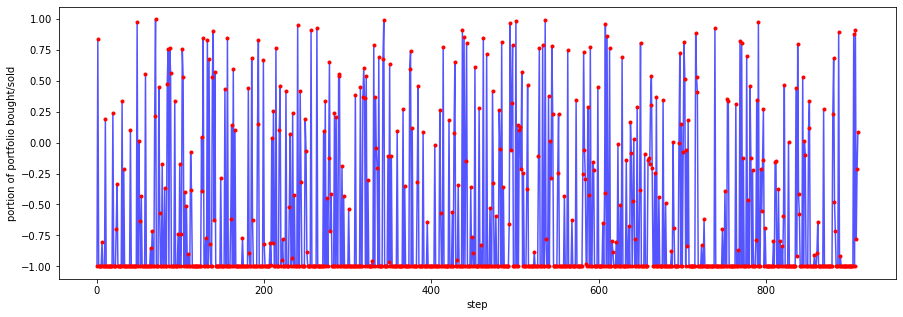

In [88]:
plt.figure(figsize=(15,5))
plt.plot(history[i]['actions'], 'b-', alpha=0.6667)
plt.plot(history[i]['actions'], 'r.')

plt.xlabel('step')
plt.ylabel('portion of portfolio bought/sold')
plt.show();

In [89]:
rewards = np.array([history[i]['rewards'] for i in np.arange(len(history))])

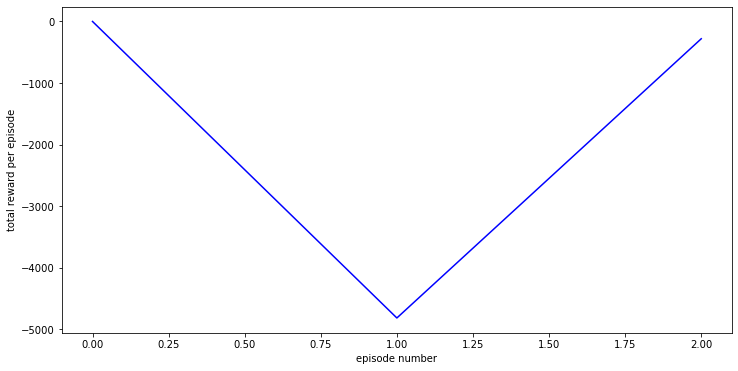

In [90]:
plt.figure(figsize=(12,6))
plt.plot(rewards[:-8], 'b-')
plt.xlabel('episode number')
plt.ylabel('total reward per episode')
plt.show();

In [91]:
print(corr(history[i]['stock'], history[i]['actions']))

0.025046268263147948
